In [1]:
import pandas as pd
import numpy as np
import os
import re
# importing required modules 
from tqdm.notebook import tqdm
from pdfminer import high_level
import requests
import ast  # for string to list: ast.literal_eval()
from bs4 import BeautifulSoup

In [10]:
resp = requests.get("https://www.parlament.hu/orszaggyulesi-naplo")

In [11]:
soup = BeautifulSoup(resp.content,"html.parser")

In [12]:
link_list = ["https://www.parlament.hu/" + file.get("href") for file in soup.select("tbody a")]

In [13]:
link_list[176]

'https://www.parlament.hu//documents/10181/1569934/ny180604/51230b5b-cc93-14b2-86aa-d59bf33283b6'

In [14]:
link_list[176].split("/")[7] + ".pdf"

'ny180604.pdf'

In [15]:
for link in tqdm(link_list):
    response = requests.get(link)
    
    with open("naplok/" + link.split("/")[7], "wb") as f:
        f.write(response.content)

KeyboardInterrupt: 

In [3]:
string = high_level.extract_text("naplok/ny201103-ossze.pdf")
df = pd.DataFrame(string.split("ELNÖK: "))

In [25]:
def clean_text(df):
    try:
        stopwords = [
            df.loc[0, 0].split("Az ülésen jelen voltak:")[1].split("\n\n")[-4].strip(),
            "-\n",
            "\n",
            "\x0c",
        ]
    except IndexError:
        stopwords = [
            df.loc[0, 0].split("Az ülésen jelen volt:")[1].split("\n\n")[-4].strip(),
            "-\n",
            "\n",
            "\x0c",
        ]

    regex = re.compile(".*?\((.*?)\)")

    hun_letters = {
        "Á": "A",
        "É": "E",
        "Ő": "O",
        "Ö": "O",
        "Ó": "O",
        "Ü": "U",
        "Ú": "U",
        "Ű": "U",
    }

    df["name_list"] = None
    df["date"] = stopwords[0]

    for i in tqdm(range(df.shape[0])):

        # basic cleaner
        for stopword in stopwords:
            df.loc[i, 0] = df.loc[i, 0].replace(stopword, "").strip()

        # delete comments
        result = re.findall(regex, df.loc[i, 0])
        result.append("()")

        for res in result:
            df.loc[i, 0] = df.loc[i, 0].replace(res, "").strip()

        # hungarian ÁÉÖŐÓÜÚŰ to AEOU
        for letter in hun_letters.keys():
            df.loc[i, 0] = df.loc[i, 0].replace(letter, hun_letters[letter])

        # extract name list
        df.loc[i, "name_list"] = [
            item.strip()
            for item in re.findall("[A-Z\s]+", df.loc[i, 0])
            if len(item.strip()) > 6
        ]

    df = df.loc[df["name_list"].apply(len) != 0].iloc[1:-1, :].reset_index(drop=True)

    df["name"] = df["name_list"].apply(lambda x: x[0])

    df["text"] = df.apply(lambda x: x[0].split(x["name"])[-1].strip(), axis=1)

    for i in range(df.shape[0]):
        if df.loc[i, "text"][0] == ":":
            df.loc[i, "text"] = df.loc[i, "text"][1:].strip()
        else:
            df.loc[i, "text"] = " ".join(df.loc[i, "text"].split(":")[1:])

    df["len"] = df["text"].apply(len)
    df = df.rename(columns={0: "raw"})

    return df

In [16]:
file_list = ["naplok/" + string for string in os.listdir("naplok/")]

In [5]:
file_list[39]

'naplok/ny200502-unnepiules.pdf'

In [17]:
if "naplok/.DS_Store" in file_list:
    file_list.remove("naplok/.DS_Store")


file_list.remove("naplok/ny200502-unnepiules.pdf")

In [23]:
file_list[46]

'naplok/ny190311.pdf'

In [29]:
string = high_level.extract_text(file_list[47])
df = pd.DataFrame(string.split("ELNÖK: "))

In [30]:
clean_text(df)

,raw,name_list,date,name,text,len
0,Az Országgyűlés őszi ülésszakának 7. ülésn...,[BANGONE BORBELY ILDIKO],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,BANGONE BORBELY ILDIKO,"Köszönöm szépen, elnök úr. Tisztelt Allamtitká...",4314
1,"Köszönöm, képviselő asszony. Válaszadásra m...",[RETVARI BENCE],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,RETVARI BENCE,Köszönöm szépen a 3389 3390 szót. Tiszte...,5162
2,"Köszönöm szépen, államtitkár úr. Szintén napi...",[GRECZY ZSOLT],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,GRECZY ZSOLT,"Köszönöm a szót, elnök úr. Tisztelt Ház! Mé...",5247
3,"Köszönöm, képviselő úr. Az elhangzottakra a ...",[VOLNER PAL],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,VOLNER PAL,"Köszönöm a szót, elnök úr. Tisztelt Há...",4836
4,"Köszönöm, államtitkár úr. Szintén napirend...",[SZABO TIMEA],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,SZABO TIMEA,"Köszönöm a szót, elnök úr. Tisztelt Képvisel...",4609
...,...,...,...,...,...,...
88,"Köszönöm szépen, képviselő asszony. Tisztel...",[UNGAR PETER],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,UNGAR PETER,Köszönöm szépen a szót. A lelki egészség na...,5177
89,"Köszönöm szépen, képviselő úr. Tisztelt Ország...",[FONAGY JANOS],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,FONAGY JANOS,"Köszönöm, elnök úr. Tisztelt Ház! Tisztelt Kép...",3777
90,"Köszönöm szépen, képviselő úr. Tisztelt Ország...",[HAJDU LASZLO],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,HAJDU LASZLO,Tisztelt Elnök Ur! Tisztelt Ház! Szeptember...,4351
91,"Köszönöm szépen, képviselő úr. Tisztelt Ország...",[KARPAT DANIEL],Az Országgyűlés őszi ülésszakának 7. ülésnapja...,KARPAT DANIEL,Tisztelt Elnök Ur! Tisztelt Ház! A rendszer...,5315


In [9]:
adf_concated = pd.DataFrame()
for file in tqdm(file_list):
    string = high_level.extract_text(file)
    df = pd.DataFrame(string.split("ELNÖK: "))
    df = clean_text(df)

    df_concated = pd.concat([df_concated, df])

KeyboardInterrupt: 

In [12]:
df = pd.read_pickle("text_speeches.pkl").reset_index(drop=True)
df["name"] = df["name"].str.replace("  "," ")

In [21]:
df.loc[600,"name"]

'UNGAR  PETER'

In [528]:
df_concated.loc[df_concated["len"]<1000].shape

(447, 6)

In [529]:
df_concated.shape

(2482, 6)

In [50]:
df.loc[df["len"]>30000].loc[13693,"text"]

k összesen 41 szervezetnél tárt fel a zárszámadásitörvény-javaslatban  szereplő  adatok  megbízhatóságát,  illetve a  2019-es központi  költségvetés végrehajtásának  szabályszerűségét  ugyan  nem  befolyásoló,  de  szabálytalanságokat,  hiányosságokat, amelyekre az ASZ levélben hívta fel az érintett vezetők figyelmét a jogszabályok keretei között. A figyelemfelhívásokban rögzített szabálytalanságok a számvitel, a könyvvezetés, a kötelezettségvállalás, valamint a kifizetést megelőző kontrollok működésének témaköreit érintették.  Rendkívül  előremutatónak  tartom,  hogy  a  41 szervezet többsége már az ellenőrzés során intézkedéseket tett a feltárt hibák kijavítása érdekében, és épp tegnap további, eddig még feledékeny szervezetek vezetőinek küldtem ismét levelet.  Felhívom a figyelmet arra is, hogy az Országgyűlés döntéshozatali munkájának hatékonyabb és eredményesebb támogatása érdekében a jelentésünk függeléke tartalmazza az Országgyűlés felé beszámolásra kötelezett intézmények zárszá

<AxesSubplot:>

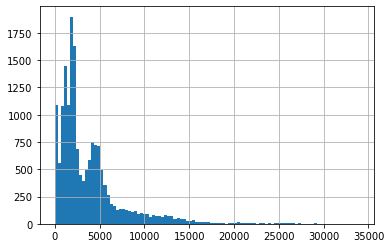

In [41]:
df["len"].hist(bins=100)

In [33]:
df["name"] = df["name"].str.replace("  "," ")